In [13]:
import numba
from numba import jit
import numpy as np
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import matplotlib.pyplot as plt
% matplotlib inline

# The Multiple-Try Metropolis and its Variations

## Abstract

Markov Chain Monte Carlo (MCMC) has been extensively applied in many complicated computational problems to sample from an arbitrary distribution. The fundamental idea is to generate a Markov chain whose invariant distribution is the target distribution. The traditional Metropolis-Hastings algorithm (MH) based on local search may suffer from slow converging problem since the sampler may get stuck in a local mode especially for multimodal parameter spaces. Multiple-try Metropolis (MTM) was proposed to overcome this difficulty by proposing multiple trial points and then sampling based on their importance. The numerical experiments illustrate that the sampler can efficiently explore the parameter space. This project will prove the validity of MTM and implement the algorithm and its variations including Griddy-Gibbs Multiple-Try Metropolis (MTM-Gibbs) and Langevin-within-MTM on artificial data and real dataset. Comparisons are made to show the superiority of the algorithm over traditional MH algorithms.

## 1. Introduction

Monte Carlo statistical methods have been widely recognized as a essential part of the standard set of scientific computing. Particularly, MCMC has been extensively applied in many complicated computational problems in many different fields. The conceptual understanding about this algorithm is to draw samples approximately distributed from  a target distribution without directly sampling from it by constructing an ergodic Markov chain with the target distribution as the invariant distribution.

The traditional MH algorithm is one of the representatives of MCMC. This fundamental algorithm is powerful in the sense that it is highly flexible and can be adapted in terms of specific problems. One commonly used variation of the MH algorithm is the Gibbs sampler which ameliorate the difficulty that sampling from a multivariate distribution by alternatively sampling from the conditional distribution of each component. However, the key feature of these algorithms--proposing new trial samples based on local moves--often lead to unsatisfactory properties of the samples. Specifically, the algorithms may suffer from slow convergence and the samples can be highly correlated which result in the difficulty on making statistical inferences. In addition, trapping in local mode is also a major imperfection of this algorithm. 

A natural idea is to enlarge the area for the proposal while it often comes along a small MH ratio resulting in an inefficient algorithm. To mitigate this problem, Liu, Liang and Wong (2000) proposed MTM method. This method differs from the classical MH by proposing a multiple candidate points rather than a simple point for each iteration. As a result, the algorithm is more robust and efficient for effectively exploring the state space of parameters.

This project intends to study the MTM algorithm to a further extent. Since no existing code was found on these methods, we will concentrate on developing code of them rather than providing a highly optimized code (Note that it is limited to optimize the code for MCMC algorithm since to build a Markov chain, the algorithm has to be implemented sequentially rather than in parallel.). The rest of this project is organized as follows. In section 2, A general form of the MTM algorithm is provided and theoretically proved to be valid. Two variations, MTM-Gibbs and Langevin-within-MTM, are discussed. In section 3, the algorithms are implemented on two artificial examples and one real dataset. Comparisons with other state-of-the-art algorithms are made to demonstrate the superiority of the MTM algorithm. We optimize the code in section 4, and conclude with some final comments in section 5.

## 2. The algorithm and its variations

In this section, we will introduce the multiple-try metropolis as well as its variations. In the traditional MH algorithm, some basic settings are as follows. Firstly, let $T(x_i,x_{i+1})$ be a transition function which defines the probability that transition from $x_i$ to $x_{i+1}$. Next, a score function used for evaluating trial points is defined as follows,
\begin{equation*}
w(x_i,x_{i+1}) = \pi(x_i) T(x_i,x_{i+1}) \lambda (x_i,x_{i+1})
\end{equation*}
where $\pi$ is the target distribution and $\lambda (x_i,x_{i+1})$ is an adjustment function to enhance the power of the algorithm, which is nonnegative and symmetric.

Two basic requirements should be satisfied.
1. $T(x_{i},x_{i+1})  > 0$ if and only if $T(x_{i+1},x_i)  > 0$
2. If $T(x_{i},x_{i+1})  > 0$, then $\lambda (x_i,x_{i+1}) >0$
The choices of $\lambda (x_i,x_{i+1})$ may vary under different situations. 

### 2.1 General form of Multiple-try Metropolis

#### 2.1.1 Algorithm

The MTM algorithm can be achieved through 4 steps.  
1. Sample $k$ iid trials $x_{t+1}^{1},..., x_{t+1}^{k}$ from $T(x_i, \cdot)$. Compute $w(x_{t+1}^{j},x_{t})$ for $j=1,...,k$.
2. Select $x = x_{t+1}$ among the proposal set $\{x_{t+1}^{1},..., x_{t+1}^{k}\}$ with probability propotional to $\{w(x_{t+1}^{1},x_t),...,w(x_{t+1}^{k},x_t)\}$.
3. Sample $x_{\star}^{1},...,x_{\star}^{k-1}$ from the distribution $T(x_{t+1},\cdot)$, and let $x_{\star}^{k}=x_{t}$.
4. Accept $x$ with probability 
$$
r = \text{min}\left\{ 1, \frac{w(x_{t+1}^{1},x_{t})+\cdot \cdot \cdot+w(x_{t+1}^{k},x_{t})} {w(x_{\star}^{1},x_{t+1})+\cdot \cdot \cdot+w(x_{\star}^{k},x_{t+1})} \right\}
$$
and reject it with probability $1-r$. The quantity $r$ is called generlaized MH ratio. 

#### 2.1.2 Theoretical Justification

The reversibility of the Markov chain is justified by proving the detailed balance condition.

Let $P(x_{i},x)$ be the actual transition probability from $x_{i}$ to $x$.  Then we have
\begin{align*}
\pi(x_i)P(x_{i},x)&=\pi(x_i)\mathsf{P}\bigg[\bigcup_{j=1}^k\{(x_{i+1}^j=x)\cap (x_{i+1}^j \text{is chosen})\}x_{i}\bigg]\\
&=k\pi(x_i)\mathsf{P}[(x_{i+1}^k=x)\cap (x_{i+1}^k \text{is chosen})\}x_{i}]\quad \text{(since $x_{i+1}^j$ are exchangeable)}\\
&=k\pi(x_i)\int\cdots\int T(x_{i},x)T(x_{i},x_{i+1}^1)\cdots T(x_{i},x_{i+1}^{k-1})\quad \text{(choosing $y,y_1,...,y_{k-1}$)}\\
&\quad\times \frac{w(x,x_{i})}{w(x,x_{i})+\sum_{j=1}^{k-1}w(x_{i+1}^j,x_i)}\quad \text{(selecting $y$)}\\
&\quad\times \text{min}\left\{ 1, \frac{w(x,x_{i})+\sum_{j=1}^{k-1}w(x_{i+1}^{j},x_{i})}{w(x_{i},x)+\sum_{j=1}^{k-1}w(x_{\star}^{j},x)} \right\}\quad \text{(accepting $y$)}\\
&\quad\times T(x,x_{\star}^1)\cdots T(x,x_{\star}^{k-1})d x_{i+1}^1\cdots dx_{i+1}^{k-1}dx_{\star}^1\cdots dx_{\star}^{k-1}\quad \text{(choosing $x_{\star}^1,...,x_{\star}^{k-1}$)}\\
&=k\frac{w(x_{i},x)w(x,x_{i})}{\lambda(x_{i},x)}\int\cdots\int \text{min}\left\{ \frac{1}{w(x,x_{i})+\sum_{j=1}^{k-1}w(x_{i+1}^j,x_{i})}, \frac{1}{w(x_{i},x)+\sum_{j=1}^{k-1}w(x_{\star}^{j},x)} \right\}\\
&\quad\times T(x,x_{\star}^1)\cdots T(x,x_{\star}^{k-1})d x_{i+1}^1\cdots dx_{i+1}^{k-1}dx_{\star}^1\cdots dx_{\star}^{k-1}\\
&=\pi(x)P(x,x_{i})
\end{align*}

Therefore, this method will produce an ergodic Markov chain leaving $\pi$ as the invariant distribution.

### 2.2 Two variations

#### 2.2.1 Griddy Gibbs Multiple-Try Metropolis

One of the major characteristic of the Gibbs sampler is that it is constructed based on the conditional distribution. However, in many cases, it is intractable to derive the conditional distribution analytically for sampling. The griddy Gibbs sampler (Ritter and tanner (1992)) solves this computational challenge by assigning grids for each component and approximating the target conditional distributions through evaluating the values of conditional distributions on grids. However, when the dimension of joint distribution is high or the conditional distribution is not concentrated on a small support. This approximation can be very computationally expensive and not accurate. 

Combining Gibbs sampler with MTM method, the MTM-Gibbs algorithm is designed to imitate the behaviour of Griddy Gibbs but has a much less computation cost and the invariant distribution is exactly the target distribution instead of approximation. Assume $\pi(x)$ is a $d$-dimensional target distribution. Let $x =(x(1),...,x(d))$, the algorithm of MTM-Gibbs is illustrated as follows,

1. Select any element of $x$, say $x(i)$. Sample $y_1,..., y_k$ iid from a transition function $T(x(i),.)$ in line with the direction of $x(i)$, and calculate 
\begin{equation*}
w(y_j,x(i)) = \pi(x(1),...,x(i-1),y_j,x(i+1),...,x(d)) T(y_j,x(i)) \lambda(y_j,x(i)),
\end{equation*}
for j = 1,2,...,k.

2. Select $y=y_j$ with probability proportional to $w(y_j,x(i))$. 

3. Draw $k-1$ iid samples from T(y,\cdot), denote by $s_1,...,s_{k-1}$. Make $s_k=x(i)$.

4. Compute the generalized Metropolis ratio $r$ defined above, accept $y$ with probability $r$ and reject it with $1-r$.

#### 2.2.2 Langevin-within-MTM

Hamiltonian Monte Carlo (HMC) has gained increasingly interest in statistical and machine learning. It takes advantage of the derivative of the pdf (up to a normalizing constant) of the target distribution and lead to a highly efficient sampling algorithm. However, it is widely misused in many fields since people do not check state spaces before performing HMC algorithms. When the state space is multimodal, the algorithm can easily get stuck in a local mode by using the derivatives lead to undesired slow convergence and biased estimation. 

Here we consider combining Langevin sampling method (a special case of HMC, take one step at each time) with MTM to provide a more reliable and robust algorithm which can explore the state space sufficiently large. Hamiltonian dynamics can be intrinsically embedded within the MTM as follows,

1. Sample $k$ iid trials $x_{t+1}^{1},..., x_{t+1}^{k}$ using Langevin dynamics. Compute $w(x_{t+1}^{j},x_{t})$ for $j=1,...,k$.
2. Select $x = x_{t+1}$ among the proposal set $\{x_{t+1}^{1},..., x_{t+1}^{k}\}$ with probability propotional to $\{w(x_{t+1}^{1},x_t),...,w(x_{t+1}^{k},x_t)\}$.
3. Sample $x_{\star}^{1},...,x_{\star}^{k-1}$ using Langevin dynamics, and let $x_{\star}^{k}=x_{t}$.
4. Accept $x$ with probability 
$$
r = \text{min}\left\{ 1, \frac{w(x_{t+1}^{1},x_{t})+\cdot \cdot \cdot+w(x_{t+1}^{k},x_{t})} {w(x_{\star}^{1},x_{t+1})+\cdot \cdot \cdot+w(x_{\star}^{k},x_{t+1})} \right\}
$$
and reject it with probability $1-r$. The quantity $r$ is called generlaized MH ratio. 

## 3. Implementation and comparisons

### 3.1 Illustrative example: two dimensional mixture Gaussian distribution

Gaussian mixture models are widely used in statistical modelling in both academia and industry. Efficiently sampling from mixture models is a key issue in many applications. The sampling algorithms may converge slowly if distances between modes of Gaussian distributions are large or some of Gaussians are highly correlated. We will illustrate the arguments above by performing and comparing MTM algorithm and traditional MH algorithm on a two dimensional Gaussian mixture distribution.

#### 3.1.1 Model Specification: Mixture Gaussian distribution

The target mixture Gaussian distribution is given by:

$$
\pi(x)=\frac{1}{3}\mathbf{N}_2(\mathbf{0},\mathbf{I}_2)+\frac{1}{3}\mathbf{N}_2\biggl\{\left(\begin{array}{c}
-6 \\
-6
\end{array}
\right),\left(\begin{array}{cc}
1 & 0.9 \\
0.9 & 1
\end{array}
\right)
\biggr\}+\frac{1}{3}\mathbf{N}_2\biggl\{\left(\begin{array}{c}
4 \\
4
\end{array}
\right),\left(\begin{array}{cc}
1 & -0.9 \\
-0.9 & 1
\end{array}
\right)
\biggr\}$$
This is a mixture of three Gaussian distributions and one can see that the modes of them are moderate and one of them is highly positively correlated while one of them is highly negatively correlated which is visualized in the figure below. 

In [14]:
## Gaussian mixtrue pdf contour plot

# assign grids
x = y = np.linspace(-10,8,400)
X, Y = np.meshgrid(x,y)

# evaluate pdf of each Gaussian
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, -6, -6, 0.9)
Z2 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 4, 4, -0.9)
Z3 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)

# mix three Gaussians
Z = (Z1+Z2+Z3)/3

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


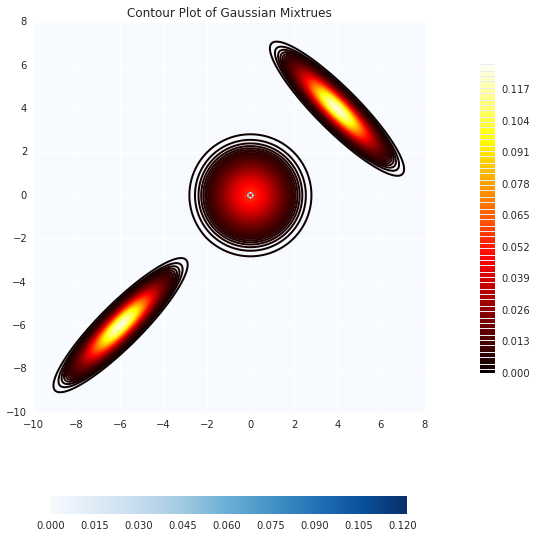

In [15]:
# figure size
plt.figure(figsize=(10,10)) 


plt.hot()                                   
im = plt.imshow(Z, interpolation='bilinear', origin='lower', cmap=cm.Blues, extent=(-10,8,-10,8))

# levels
levels = np.arange(0, 0.13, 0.001) 

CS = plt.contour(Z, levels,origin='lower',linewidths=2, extent=(-10,8,-10,8))         

CB = plt.colorbar(CS, shrink=0.8, extend='both')

CBI = plt.colorbar(im, orientation='horizontal',shrink=0.8)

l,b,w,h = plt.gca().get_position().bounds
ll,bb,ww,hh = CB.ax.get_position().bounds
CB.ax.set_position([ll, b+0.1*h, ww, h*0.8])      

plt.title('Contour Plot of Gaussian Mixtrues')  
plt.show()





****

The follwoing settings are used in our testification of the algorithm.

Initial state: 
$x_0^{i} = \text{Uni}(-5,5)\quad i = 1,2$

The proposal function $T(.)$:
$
\left(\begin{array}{c}
x_{t+1}^{1}  \\
x_{t+1}^{2} 
\end{array}
\right) = \left(\begin{array}{c}
x_{t}^{1}  \\
x_{t}^{2} 
\end{array}
\right)+\mathbf{N}_2(\mathbf{0},\sigma^2 \mathbf{I}_2)
$

The probability density function:
$$
\pi(x)=\frac{1}{3}\mathbf{N}_2(\mathbf{0},\mathbf{I}_2)+\frac{1}{3}\mathbf{N}_2\biggl\{\left(\begin{array}{c}
-6 \\
-6
\end{array}
\right),\left(\begin{array}{cc}
1 & 0.9 \\
0.9 & 1
\end{array}
\right)
\biggr\}+\frac{1}{3}\mathbf{N}_2\biggl\{\left(\begin{array}{c}
4 \\
4
\end{array}
\right),\left(\begin{array}{cc}
1 & -0.9 \\
-0.9 & 1
\end{array}
\right)
\biggr\}$$

The adjustment function $\lambda (x_i,x_{i+1}) = 1$




#### Griddy Gibbs Multiple-Try Metropolis
**Algorithm**

One of the major characteristic of the Gibbs sampler is that it is constructed based on the conditional distribution. However, in many cases, it is intracable to derive the conditional distribution for sampling. The griddy Gibbs sampler (Ritter and tanner (1992)) solves the computational challenge. Combined with MTM method, the MTM-Gibbs algorithm is designed to enhance the performance of the MTM.

Assume $\mathbf{X} = \mathbf{x}$ where $\mathbf{x}=(x(1),...,x(d))$, the algorithm of MTM-Gibbs is illustrated as follows,

1. Select any element of $\mathbf{x}$, say $x{i}$. Sample $y_1,..., y_k$ iid from a transition function $T(x(i),.)$ in line with the direction of $x(i)$, and calculate 
\begin{equation*}
w(y_j,x(i)) = \pi(x(1),...,x(i-1),y_j,x(i+1),...,x(d)) T(y_j,x(i)) \lambda(y_j,x(i)),
\end{equation*}
for j = 1,2,...,k.

2. Select $y=y_j$ with probability proportional to $w(y_j,x(i))$. Draw $k-1$ iid samples from T(y,.), denote by $s_1,...,s_{k-1}$. Make $s_k=x(i)$.

3. Compute the generalized Metropolis ratio r defined above, accept $y$ with probability $r$ and reject with $1-r$.

**Model Specification: Non-linear model**

The model used in testing the MTM-Gibbs is defined as follows,
$$y_i=\theta_1(1-\exp(-\theta_2x_i))+\varepsilon_i$$
where $y$ is the Biochemical Oxygen Demand (BOD) at time $x$ with independent normal errors with constant variance $\sigma^2$.

The following settings are used in our testification of the algorithm.

Initial state: $\theta_i = \text{Uni}(-1,1) \quad i = 1,2$

The proposal function $T(.)$:
$\theta_{t+1}^{i} = \theta_{t+1}^{i} + \mathbf{N}(0,\sigma^2)\quad i = 1,2$

The adjustment function $\lambda (x_i,x_{i+1}) = 1$


#### Langevin-within-MTM
**Algorithm**





**Model Specification: **


# Implementation

#### Multiple-try Metropolis

### Toy example

In [3]:
import numba
from numba import jit
import numpy as np
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.cm as cm
import matplotlib.pyplot as plt
% matplotlib inline

#### Sampling from a two-dimensional mixture Gaussian Distribution $\pi(x)$
$$
\pi(x)=\frac{1}{3}\mathbf{N}_2(\mathbf{0},\mathbf{I}_2)+\frac{1}{3}\mathbf{N}_2\biggl\{\left(\begin{array}{c}
-6 \\
-6
\end{array}
\right),\left(\begin{array}{cc}
1 & 0.9 \\
0.9 & 1
\end{array}
\right)
\biggr\}+\frac{1}{3}\mathbf{N}_2\biggl\{\left(\begin{array}{c}
4 \\
4
\end{array}
\right),\left(\begin{array}{cc}
1 & -0.9 \\
-0.9 & 1
\end{array}
\right)
\biggr\}$$

In [72]:
def norm_mix(x):
    target = stats.multivariate_normal.pdf(x,[0,0],[[1,0],[0,1]])+stats.multivariate_normal.pdf(x,[-6,-6],[[1,0.9],[0.9,1]])+stats.multivariate_normal.pdf(x,[4,4],[[1,-0.9],[-0.9,1]])
    return target

In [11]:
x = y = np.linspace(-10,8,400)
X, Y = np.meshgrid(x,y)
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, -6, -6, 0.9)
Z2 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 4, 4, -0.9)
Z3 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
Z = (Z1+Z2+Z3)/3

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


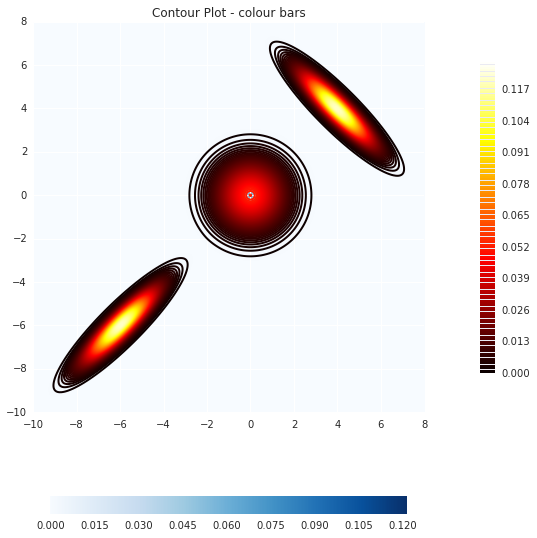

In [12]:
x = y = np.linspace(-10,8,400)
X, Y = np.meshgrid(x,y)
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, -6, -6, 0.9)
Z2 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 4, 4, -0.9)
Z3 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
Z = (Z1+Z2+Z3)/3
plt.figure(figsize=(10,10))

plt.hot()                                    # set 'hot' as default colour map
im = plt.imshow(Z, interpolation='bilinear', # creates background image
                origin='lower', cmap=cm.Blues, 
                extent=(-10,8,-10,8))

levels = np.arange(0, 0.13, 0.001)           # levels

CS = plt.contour(Z, levels,
                 origin='lower',             # origin in lower-left corner
                 linewidths=2,               # line width
                 extent=(-10,8,-10,8))         # outer pixel boundaries

CB = plt.colorbar(CS, shrink=0.8,                 # vertical colour bar
                  extend='both')

CBI = plt.colorbar(im, orientation='horizontal',  # horizontal colour bar
             shrink=0.8)

l,b,w,h = plt.gca().get_position().bounds
ll,bb,ww,hh = CB.ax.get_position().bounds
CB.ax.set_position([ll, b+0.1*h, ww, h*0.8])      # shrinks the vertical bar

plt.title('Contour Plot - colour bars')           # title

plt.show()

#### Method 1: Traditional Metropolis-Hastings sampler

In [43]:
n_iter = 50000
sigma = 2

# initial state
X = stats.uniform.rvs(loc=-5, scale=10, size=2, random_state=None)

# record the number of acceptances
accept = 0

# store the samples
MHsamples = np.zeros((n_iter,2))

# tuning parameter:
# sigma: variance of proposal

# MH sampler
for t in range(n_iter):
    # proposal: independent N(0,sigma)
    Y = X+stats.norm.rvs(0,sigma,2)
       
    # accept or reject
    u = stats.uniform.rvs(loc=0, scale=1, size=1)
    if u < norm_mix(Y)/norm_mix(X):
        X = Y
        accept += 1
    MHsamples[t] = X

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


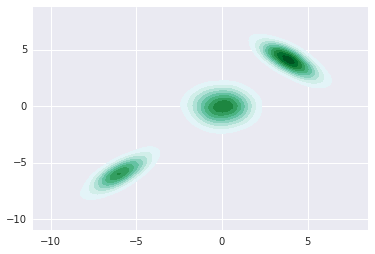

In [44]:
sns.kdeplot(MHsamples[:,0], MHsamples[:,1], camps='Reds', kind="kde",shade=True,shade_lowest=False)

#### Method 2: MTM sampler

In [ ]:
# try to write an independant mtm algorithm without model specification
def w(x,y):
    return pi(x)*T(x,y,k)*lamda(x,y) 

def MTM(start, niter,k):
    niter = 0
    L = []
    L.append(start)
    y = np.zeros(k)
    y = T(L[niter],y,k)
    w_prop = w(L[niter],y)
    ix = np.random.choice(k, 1, p=w_prop/sum(w_prop))
    x_star = T(y[ix],y,k-1)
    x_star.append(L(niter))
    w_back = w(x_star, y[ix])
    u = stats.uniform.rvs(loc=0, scale=1, size=1)
    if u < sum(w_prop)/sum(w_back):
        niter += 1
        L.append(y[ix])

#haven't test yet   

In [39]:
n_iter = 10000
M = 10
sigma = 2

In [ ]:
 Y = np.tile(X,(M,1))+stats.norm.rvs(0,sigma,(M,2))
    
    # proposal importance probabilities
    w_prop = norm_mix(Y)*T(Y,X,sigma)
    
    # index of the chosen trial point
    ix = np.random.choice(M, 1, p=w_prop/sum(w_prop))
    
    # draw M-1 samples 
    X_star = np.tile(Y[ix],(M-1,1))+stats.norm.rvs(0,sigma,(M-1,2))
    # add X as M th sample
    X_star = np.vstack((X_star,X))
    
    # back importance probabilities
    w_back = norm_mix(X_star)*T(X_star,Y[ix][0],sigma)

In [48]:
def T(x,y,sigma):
    return stats.multivariate_normal.pdf(y,x,[[sigma**2,0],[0,sigma**2]])

In [49]:
# initial state
X = stats.uniform.rvs(loc=-5, scale=10, size=2, random_state=None)

# record the number of acceptances
accept = 0

# store the samples
MTMsamples = np.zeros((n_iter,2))

# tuning parameter:
# sigma: variance of the proposal

# MTM sampler
for t in range(n_iter):
    # proposal: independent N(0,sigma)
    Y = np.tile(X,(M,1))+stats.norm.rvs(0,sigma,(M,2))
    
    # proposal importance probabilities
    w_prop = norm_mix(Y)*T(X,Y,sigma)
    
    # index of the chosen trial point
    ix = np.random.choice(M, 1, p=w_prop/sum(w_prop))
    
    # draw M-1 samples 
    X_star = np.tile(Y[ix],(M-1,1))+stats.norm.rvs(0,sigma,(M-1,2))
    # add X as M th sample
    X_star = np.vstack((X_star,X))
    
    # back importance probabilities
    w_back = norm_mix(X_star)*T(Y[ix][0],X_star,sigma)
    
    # accept or reject
    u = stats.uniform.rvs(loc=0, scale=1, size=1)
    if u < sum(w_prop)/sum(w_back):
        X = Y[ix][0]
        accept += 1
    MTMsamples[t] = X

In [41]:
accept

6353

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


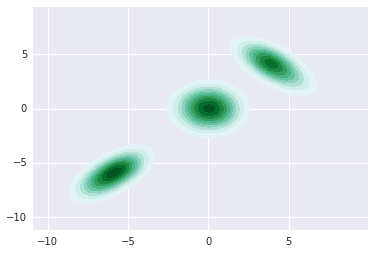

In [42]:
sns.kdeplot(MTMsamples[:,0], MTMsamples[:,1], camps='Reds', kind="kde",shade=True,shade_lowest=False)

# Also need to compare autocorrelation, acceptance here

## Variation 1: Griddy Gibbs Multiple-Try Metropolis

### Real dataset: Biochemical Oxygen Demand (BOD) originally from Marske (1967)

In [132]:
data = pd.read_table('BOD.txt',sep='|')
data.head()

,Time,demand
1,1,8.3
2,2,10.3
3,3,19.0
4,4,16.0
5,5,15.6


### Non-linear model was fitted based on the analysis from Bates, D.M. and Watts, D.G. (1988)

The non-linear model is given by
$$y_i=\theta_1(1-\exp(-\theta_2x_i))+\varepsilon_i$$
where $y$ is the BOD at time $x$ with independent normal errors with constant variance $\sigma^2$.

In [133]:
x = data.ix[:,0]
y = data.ix[:,1]

In [134]:
def post(theta1, theta2):
    n = len(x)
    if theta1 > -20 and theta1 < 50 and theta2 > -2 and theta2 < 6:
        posterior = sum((y - theta1*(1-np.exp(-theta2*x)))**2)**(-(n/2)+1)
    else: posterior = 0
    return posterior

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


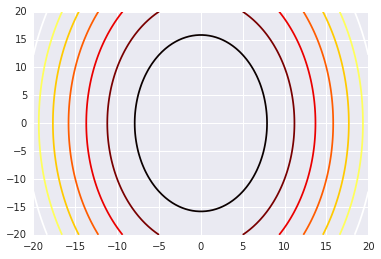

In [136]:
xx = np.linspace(-20, 20, 100)
yy = np.linspace(-20, 20, 100)
Z = np.zeros((len(xx), len(yy)))

for i in range(len(xx)):
    for j in range(len(yy)):
        Z[i, j] = 4*xx[i]**2 + yy[j]**2
        
plt.contour(xx, yy, Z.T)

In [148]:
xaxis = np.linspace(-20.0, 40.0, 120)
yaxis = np.linspace(0.0, 6.0, 120)
Z = np.zeros((len(xaxis), len(yaxis)))

xaxis[20]

-9.9159663865546221

In [151]:
xaxis = np.linspace(-20.0, 40.0, 120)
yaxis = np.linspace(-2.0, 4.0, 120)
Z = np.zeros((len(xaxis), len(yaxis)))

for i in range(len(xaxis)):
    for j in range(len(yaxis)):
        Z[i, j] = post(xaxis[i],yaxis[j])

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


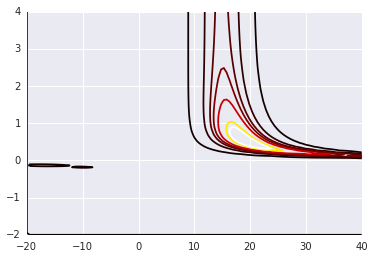

In [179]:
plt.contour(xaxis, yaxis, Z.T, levels=[0,0.00001,0.00004,0.00008,0.00012,0.00020,0.0005,0.0007])

In [158]:
n_iter = 10000
M = 10
# tuning parameter:
# sigma1, sigma2: variance of the proposal
sigma1 = 30
sigma2 = 3

In [159]:
def T(x,y,sigma):
    return stats.norm.pdf(y,x,sigma)

In [160]:
# MTM-Gibbs sampler
def MTMG(n_iter, M, sigma1, sigma2, post):
    
    # initial state
    theta1, theta2 = stats.uniform.rvs(loc=-1, scale=2, size=2, random_state=None)

    # record the number of updates for each component
    count1 = count2 = 0

    # record the number of acceptances
    accept1 = accept2 = 0
    
    # store the samples
    MTMGsamples = np.zeros((n_iter,2))

    for t in range(n_iter):
    
        # randomly pick the updating component
        index = stats.bernoulli.rvs(0.5,1)
    
        # update theta1
        if index == 1:
        
            # record number of updating
            count1 += 1
        
            # proposal: N(theta1,sigma1^2)
            theta1_prop = np.repeat(theta1,M)+stats.norm.rvs(0,sigma1,M)
    
            # proposal importance probabilities
            w_prop = np.array([post(theta1,theta2) for theta1 in theta1_prop])*T(theta1_prop,theta1,sigma1)
     
            # index of the chosen trial point
            ix = np.random.choice(M, 1, p=w_prop/sum(w_prop))
    
            # draw M-1 samples 
            theta1_star = np.repeat(theta1_prop[ix],M-1)+stats.norm.rvs(0,sigma1,M-1)
            # add theta1 as M th sample
            theta1_star = np.append(theta1_star,theta1)
    
            # back importance probabilities
            w_back = np.array([post(theta1,theta2) for theta1 in theta1_star])*T(theta1_star,theta1_prop[ix],sigma1)
    
            # accept or reject
            u = stats.uniform.rvs(loc=0, scale=1, size=1)
            if u < sum(w_prop)/sum(w_back):
                theta1 = theta1_prop[ix]
                accept1 += 1
            
        # update theta2
        else: 
        
            # record number of updating
            count2 += 1
        
            # proposal: N(theta2,sigma2^2)
            theta2_prop = np.repeat(theta2,M)+stats.norm.rvs(0,sigma2,M)
    
            # proposal importance probabilities
            w_prop = np.array([post(theta1,theta2) for theta2 in theta2_prop])*T(theta2_prop,theta2,sigma2)
    
            # index of the chosen trial point
            ix = np.random.choice(M, 1, p=w_prop/sum(w_prop))
    
            # draw M-1 samples 
            theta2_star = np.repeat(theta2_prop[ix],M-1)+stats.norm.rvs(0,sigma2,M-1)
            # add theta2 as M th sample
            theta2_star = np.append(theta2_star,theta2)
    
            # back importance probabilities
            w_back = np.array([post(theta1,theta2) for theta2 in theta2_star])*T(theta2_star,theta2_prop[ix],sigma2)
    
            # accept or reject
            u = stats.uniform.rvs(loc=0, scale=1, size=1)
            if u < sum(w_prop)/sum(w_back):
                theta2 = theta2_prop[ix]
                accept2 += 1
            
        MTMGsamples[t] = theta1, theta2
    
    return MTMGsamples, count1, count2, accept1, accept2

In [161]:
MTMGsamples, count1, count2, accept1, accept2 = MTMG(n_iter=n_iter, M=M, sigma1=sigma1, sigma2=sigma2, post=post)

/opt/conda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


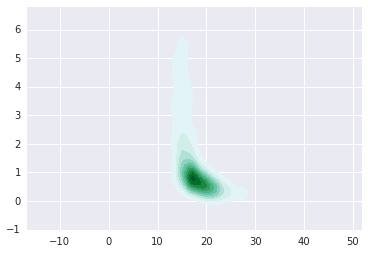

In [195]:
sns.kdeplot(MTMGsamples[:,0], MTMGsamples[:,1], camps='Reds', kind="kde",shade=True,shade_lowest=False)

## Variation 2: Langevin-within-MTM

In [4]:
@jit
def U(theta):
    return (theta+4)*(theta+1)*(theta-1)*(theta-3)/14+0.5

In [5]:
@jit
def grad_U(theta):
    return 1/14*(4*theta**3+3*theta**2-26*theta-1)

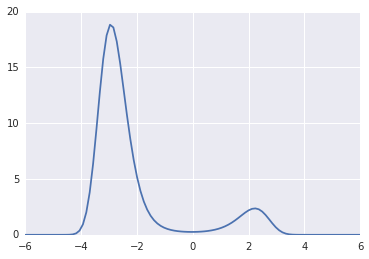

In [11]:
x = np.linspace(-6, 6, 100)
plt.plot(x, np.exp(-U(x)))
pass

In [20]:
def Langevin(U, grad_U, eps, current_q, M):
    
    q = current_q
    
    p = np.random.randn(M)
    current_p = p
    
    p = p - eps * grad_U(q)/2
    
    q = q + eps * p
            
    p = p - eps * grad_U(q)/2
    
    p = -p
    
    current_U = U(current_q)
    current_K = current_p**2/2
    proposed_U = U(q)
    proposed_K = p**2/2
        
    w = np.exp(current_U-proposed_U+current_K-proposed_K)
        
    return q,w

In [48]:
n_iter = 50000
M = 5
# tuning parameter:
eps=0.1

In [57]:
# initial state
q = stats.uniform.rvs(loc=-6, scale=12, size=1, random_state=None)

# record the number of acceptances
accept = 0

# store the samples
MTMsamples = np.zeros(n_iter)

# tuning parameter:
# sigma: variance of the proposal

# MTM sampler
for t in range(n_iter):
        
    # proposal importance probabilities
    q_prop, w_prop = Langevin(U, grad_U, eps=eps, current_q=q, M=1)
    
    u = stats.uniform.rvs(loc=0, scale=1, size=1)
    if u < w_prop:
        q = q_prop
        accept += 1
    MTMsamples[t] = q

In [67]:
# initial state
q = stats.uniform.rvs(loc=-6, scale=12, size=1, random_state=None)

# record the number of acceptances
accept = 0

# store the samples
MTMsamples = np.zeros(n_iter)

# tuning parameter:
# sigma: variance of the proposal

# MTM sampler
for t in range(n_iter):
        
    # proposal importance probabilities
    q_prop, w_prop = Langevin(U, grad_U, eps=eps, current_q=q, M=M)
    
    # index of the chosen trial point
    ix = np.random.choice(M, 1, p=w_prop/sum(w_prop))
    
    # draw M-1 samples 
    q_star, w_back = Langevin(U, grad_U, eps=eps, current_q=q_prop[ix], M=M-1)
    
    # add X as M th sample
    q_star = np.append(q_star,q)
    
    # back importance probabilities
    p = (q-q_prop[ix])/eps
#     (p+eps*grad_U(q_prop[ix]))**2/2
# -(p-eps * grad_U(q)/2)**2/2

    w_back = np.append(w_back,np.exp(U(q_prop[ix])+(p+eps*grad_U(q_prop[ix]))**2/2-U(q)-(p-eps * grad_U(q)/2)**2/2))
    
    # accept or reject
    u = stats.uniform.rvs(loc=0, scale=1, size=1)
    if u < sum(w_prop)/sum(w_back):
        q = q_prop[ix]
        accept += 1
    MTMsamples[t] = q

In [44]:
MTMsamples,accept

(array([ 4.30480327,  4.16442865,  4.02200488, ...,  1.76202681,
         1.71432992,  1.57445896]), 9892)

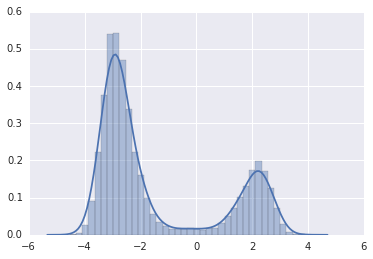

In [68]:
sns.distplot(MTMsamples)

# Experimental Results and Comparisons

# Profiling and Optimization

In the analysis above, we present three algorithms belonging to the MTM class. Considering the maturity and convexity of each algorithm, we choose to explore the MTM-gibbs to a further extent.

In [ ]:
# I just thought about working more on MTM_gibbs. but be free choose 
# other algorithm to work on with. 


In [69]:
%prun MTMG(n_iter=n_iter, M=M, sigma1=sigma1, sigma2=sigma2, post=post)

NameError: name 'MTMG' is not defined

![cprofile](cprofile.png)

The basic code was written in common packages such as numpy and scipy. We profiled the code using $cProfile$ to figure out bottlenecks. The result is shown as above. As can been seen, the part that takes most of the time is the posterior function. 

# Conclusion